# Embedding Model

In [119]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [120]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [122]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Deep Embedding Clustering (DEC) Model

In [123]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform')

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

class DEC:
    def __init__(self, input_dim, encoding_dim, n_clusters, dropout_rate=0.2):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.n_clusters = n_clusters
        self.dropout_rate = dropout_rate
        self.autoencoder, self.encoder = self.build_autoencoder()
        self.model = self.build_dec_model()

    def build_autoencoder(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dropout(self.dropout_rate)(encoder)
        encoder = Dense(self.encoding_dim, activation='relu', kernel_initializer='glorot_uniform')(encoder)

        decoder = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(encoder)
        decoder = Dropout(self.dropout_rate)(decoder)
        decoder = Dense(self.input_dim, activation='sigmoid', kernel_initializer='glorot_uniform')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mse')

        encoder_model = Model(inputs=input_layer, outputs=encoder)
        return autoencoder, encoder_model

    def build_dec_model(self):
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        model = Model(inputs=self.encoder.input, outputs=[clustering_layer, self.autoencoder.output])
        model.compile(optimizer='adam', loss=['kld', 'mse'])
        return model

    def pretrain_autoencoder(self, data, epochs=50, batch_size=256):
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])

    def initialize_clusters(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            encoded_data = self.encoder.predict(data)
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            kmeans.fit(encoded_data)
            initial_clusters = kmeans.cluster_centers_
            self.model.get_layer(name='clustering').set_weights([initial_clusters])

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def train_dec(self, data, maxiter=8000, update_interval=140, tol=0.001):
        index = 0
        y_pred_last = None
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            for ite in range(maxiter):
                if ite % update_interval == 0:
                    q, _ = self.model.predict(data, verbose=0)
                    p = self.target_distribution(q)

                    y_pred = q.argmax(1)
                    if ite > 0 and np.sum(y_pred != y_pred_last) / len(y_pred) < tol:
                        print('Reached tolerance threshold. Stopping training.')
                        break
                    y_pred_last = np.copy(y_pred)

                idx = index * update_interval % data.shape[0]
                loss = self.model.train_on_batch(x=data[idx:idx + update_interval],
                                                 y=[p[idx:idx + update_interval], data[idx:idx + update_interval]])
                index += 1
                print('Iteration', ite, 'Loss:', loss)

    def predict(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            q, _ = self.model.predict(data)
            return q.argmax(1)

In [124]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [125]:
features

array([[0.66666667, 0.        , 1.        , ..., 0.        , 0.22590312,
        0.40428807],
       [0.66666667, 0.        , 1.        , ..., 1.        , 0.69219799,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.02590312,
        0.05800816],
       ...,
       [0.66666667, 0.        , 1.        , ..., 0.        , 0.22590312,
        0.24344734],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.07353108,
        0.05800816],
       [1.        , 0.        , 0.        , ..., 0.        , 0.8763515 ,
        0.8619974 ]])

In [126]:
features.shape

(100000, 11)

In [127]:
# Parameters
input_dim = features.shape[1]
encoding_dim = 2
n_clusters = 10
dropout_rate = 0.2

In [128]:
# Create DEC instance
dec = DEC(input_dim, encoding_dim, n_clusters, dropout_rate)

In [129]:
# Pretrain autoencoder
dec.pretrain_autoencoder(features, epochs=100, batch_size=256)

Epoch 1/100
391/391 [==============================] - 1s 3ms/step - loss: 0.1199
Epoch 2/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0720
Epoch 3/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0574
Epoch 4/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0506
Epoch 5/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0457
Epoch 6/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0415
Epoch 7/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0384
Epoch 8/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0362
Epoch 9/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0348
Epoch 10/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0332
Epoch 11/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0316
Epoch 12/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0302
Epoch 13/100


In [130]:
# Initialize clusters
dec.initialize_clusters(features)

3125/3125 [==============================] - 2s 556us/step


In [131]:
# Train DEC model
dec.train_dec(features, maxiter=8000, update_interval=140, tol=0.001)

Iteration 0 Loss: [0.25951069593429565, 0.23251108825206757, 0.02699960581958294]
Iteration 1 Loss: [0.2835724353790283, 0.2532392740249634, 0.030333148315548897]
Iteration 2 Loss: [0.26348912715911865, 0.23713035881519318, 0.02635875716805458]
Iteration 3 Loss: [0.2724878489971161, 0.23931463062763214, 0.03317321836948395]
Iteration 4 Loss: [0.2440885752439499, 0.2231905460357666, 0.020898040384054184]
Iteration 5 Loss: [0.28907081484794617, 0.2667447328567505, 0.02232607826590538]
Iteration 6 Loss: [0.3254852890968323, 0.29789817333221436, 0.027587130665779114]
Iteration 7 Loss: [0.26395073533058167, 0.23959456384181976, 0.02435617707669735]
Iteration 8 Loss: [0.2247777283191681, 0.19522292912006378, 0.02955479919910431]
Iteration 9 Loss: [0.2912062406539917, 0.2758772075176239, 0.015329021960496902]
Iteration 10 Loss: [0.24443380534648895, 0.22395013272762299, 0.020483674481511116]
Iteration 11 Loss: [0.19385036826133728, 0.17412374913692474, 0.019726617261767387]
Iteration 12 Loss:

In [132]:
# Predict clusters
clusters = dec.predict(features)
print("Predicted clusters:", clusters)

3125/3125 [==============================] - 3s 908us/step
Predicted clusters: [2 8 2 ... 2 5 0]


In [133]:
encoded_data = dec.encoder.predict(features)

3125/3125 [==============================] - 2s 579us/step


## Determine the number of clusters(k)

In [134]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(encoded_data)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


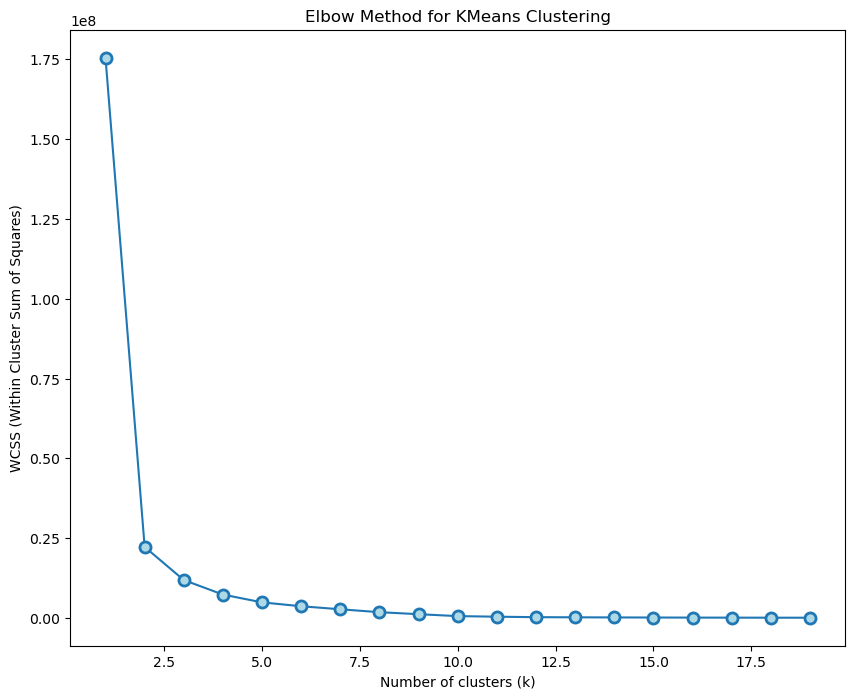

In [135]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [142]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=3, random_state=0).fit(encoded_data)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(encoded_data)
df.groupby(['cluster_kmeans']).mean()

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.632737,0.814021,0.459565,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.477646,0.438903
1,0.495237,0.718844,0.469931,0.020054,0.169609,0.192826,0.070802,0.546709,0.0,0.452445,0.403333
2,0.406823,1.000000,0.675303,0.591920,0.000000,0.000000,0.408080,0.000000,0.0,0.405699,0.376680


In [143]:
# df.mean()

In [144]:
df.cluster_kmeans.value_counts()

1    79984
2    10074
0     9942
Name: cluster_kmeans, dtype: int64

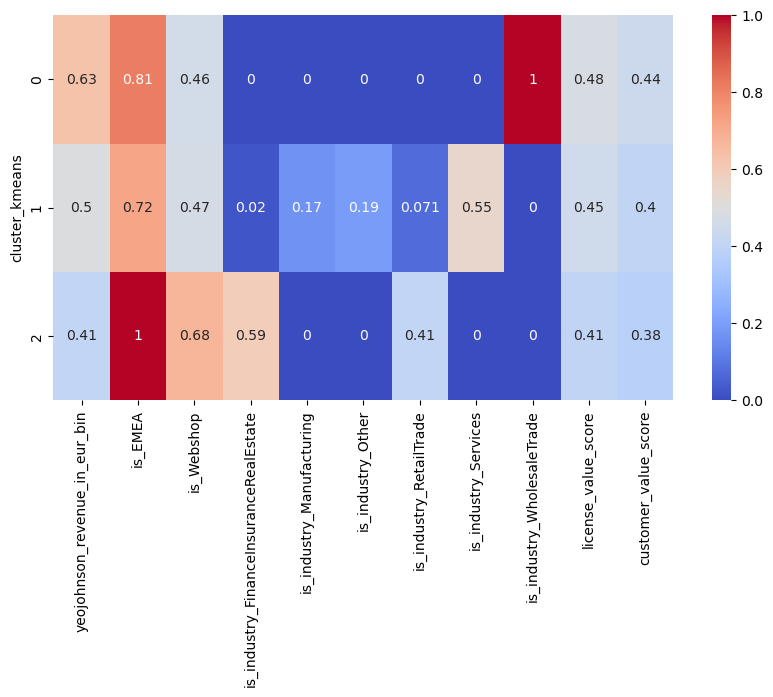

In [145]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [146]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

## Evaluation

In [147]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.148


In [148]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 2.022


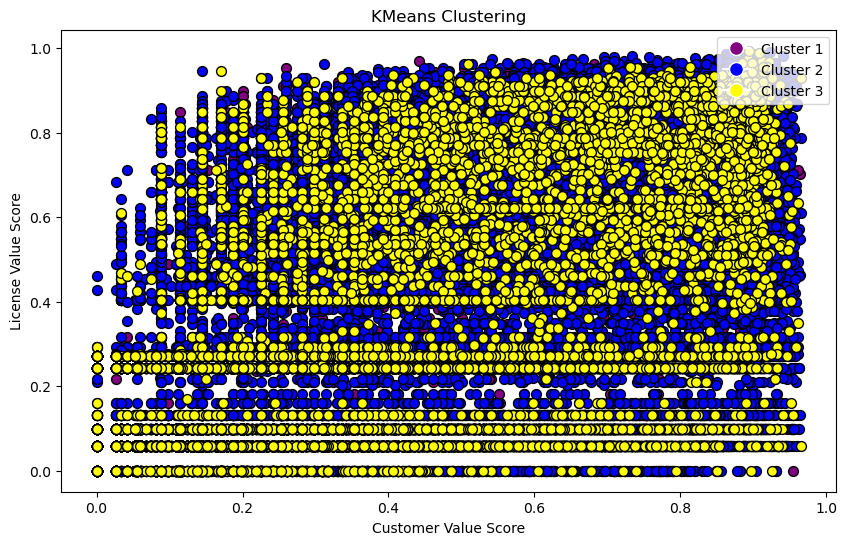

In [149]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()